# Extract Data Characteristics from the RADx-rad Project

Data Characteristics
* Sample/specimen type: inactivated virus, saliva, nasal swabs, odor, etc.
* SARS-CoV-2 variants and common respiratory viruses use for validation
* WHO Labels of SARS-CoV-2 variants
* Virus inactivation methods to create inactivated viruses (use for spiked samples)

Author: Peter W Rose, UC San Diego (pwrose.ucsd@gmail.com)

Data last updated: 2025-06-09

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [2]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Ensure plots display inline
%matplotlib inline

In [3]:
# Results directory
result_dir = "../../results"

In [4]:
df = pd.read_csv(os.path.join(result_dir, "data_elements.csv"), dtype=str)
df = df[["Id", "subproject", "phs_id", "project_num", "radx_id", "tier", "filename"]].copy()
df["filename"].head()

0    ../../phs002522/rad_035_410-01_11845_Rapid1_DATA_origcopy.csv
1    ../../phs002522/rad_035_410-01_11845_Rapid1_DATA_origcopy.csv
2    ../../phs002522/rad_035_410-01_11845_Rapid1_DATA_origcopy.csv
3    ../../phs002522/rad_035_410-01_11845_Rapid1_DATA_origcopy.csv
4    ../../phs002522/rad_035_410-01_11845_Rapid1_DATA_origcopy.csv
Name: filename, dtype: object

In [5]:
def extract_data_element(df, data_elements):
    extract_list = []

    for _, row in df.iterrows():
        data_element_id = row["Id"]
        phs_id = row["phs_id"]
        sub_project = row["subproject"]
        data_file = row["filename"]

        if data_element_id in data_elements:
            data = pd.read_csv(data_file, dtype=str, usecols=[data_element_id], keep_default_na=False)
            data.drop_duplicates(subset=data_element_id, inplace=True)
            data.rename(columns={data_element_id: "value"}, inplace=True)
            data["characteristic"] = data_element_id
            data["phs_id"] = phs_id
            data["subproject"] = sub_project
            extract_list.append(data)

    extracted_data = pd.concat(extract_list, ignore_index=True)
    extracted_data.drop_duplicates(inplace=True)

    return extracted_data

In [6]:
# Field names that contain specimen information
SPECIMEN_COLUMNS = [
    "specimen_type",
    "virus_sample_type",
    "sample_media",
]

In [7]:
cols = SPECIMEN_COLUMNS
characteristics = extract_data_element(df, cols)
characteristics["characteristic"] = characteristics["characteristic"].replace({
    "sample_media": "specimen_type",
    "virus_sample_type": "specimen_type"
})
# Simplify the speciment types
mask = characteristics["value"].str.contains("PBS", case=False, na=False)
characteristics.loc[mask, "value"] = "buffer"

mask = characteristics["value"].str.contains("buffer ", case=False, na=False)
characteristics.loc[mask, "value"] = "buffer"

mask = characteristics["value"].astype(str).str.contains("plasma", case=False, na=False)
characteristics.loc[mask, "value"] = "plasma"

characteristics["value"] = characteristics['value'].str.split("|")
characteristics = characteristics.explode("value")
characteristics['value'] = characteristics['value'].replace('', 'unspecified')
characteristics.sort_values(by=["characteristic", "subproject", "value"], inplace=True)

In [8]:
characteristics.to_csv(os.path.join(result_dir, "data_characteristics.csv"), index=False)

In [9]:
characteristics.head()

,value,characteristic,phs_id,subproject
104,artificial saliva,specimen_type,phs002744.v1.p1,Automatic Detection & Tracing
100,breath,specimen_type,phs002700.v1.p1,Automatic Detection & Tracing
88,inactivated virus,specimen_type,phs002546.v1.p1,Automatic Detection & Tracing
135,inactivated virus,specimen_type,phs002744.v1.p1,Automatic Detection & Tracing
87,pooled saliva,specimen_type,phs002546.v1.p1,Automatic Detection & Tracing


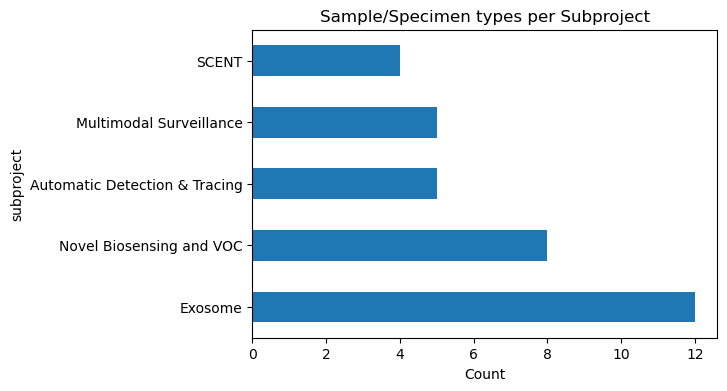

In [10]:
# Bar chart of subproject counts
characteristics['subproject'].value_counts().plot.barh(figsize=(6,4))
plt.title("Sample/Specimen types per Subproject")
plt.xlabel("Count");

In [11]:
# Wrap subproject labels after next space if >10 chars)
def wrap_label(label, limit=10):
    """Wrap subproject label into two lines if longer than limit."""
    if len(label) <= limit:
        return label
    # Find the first whitespace *after* the limit
    for i in range(limit, len(label)):
        if label[i].isspace():
            return label[:i] + '\n' + label[i+1:]
    return label

In [12]:
# Set default font globally
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14  # default for all text elements

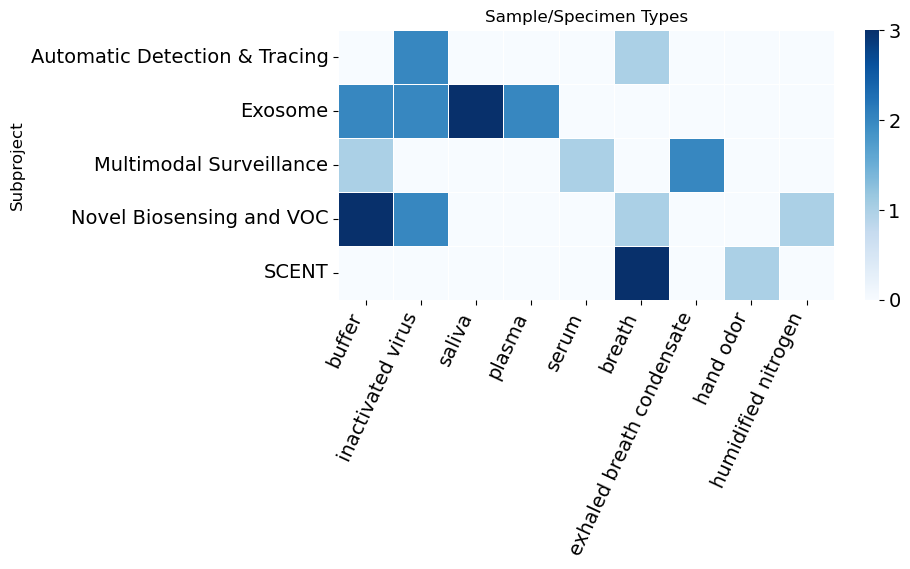

In [13]:
# Heatmap of biorecogniton_type by subproject
# desired_order = ["buffer", "phosphate buffered saline",
desired_order = ["buffer",
                 "inactivated virus",
                 "saliva", "plasma", "serum",
                 "breath", "exhaled breath condensate",
                 "hand odor", "humidified nitrogen",]
pivot = (
    characteristics[characteristics['characteristic'] == 'specimen_type']
    .pivot_table(index='subproject', columns='value', aggfunc='size', fill_value=0)
)
pivot = pivot.reindex(columns=desired_order, fill_value=0)
plt.figure(figsize=(8, 3.5))
# sns.heatmap(pivot, cmap='Blues', linewidths=0.5)
ax = sns.heatmap(pivot, cmap='Blues', linewidths=0.5)

# Force integer ticks on colorbar
colorbar = ax.collections[0].colorbar
colorbar.locator = MaxNLocator(integer=True)
colorbar.update_ticks()

plt.xticks(rotation=65, ha='right')
plt.ylabel("Subproject", fontsize=12)
plt.xlabel("")
plt.title("Sample/Specimen Types", fontsize=12)
plt.show();

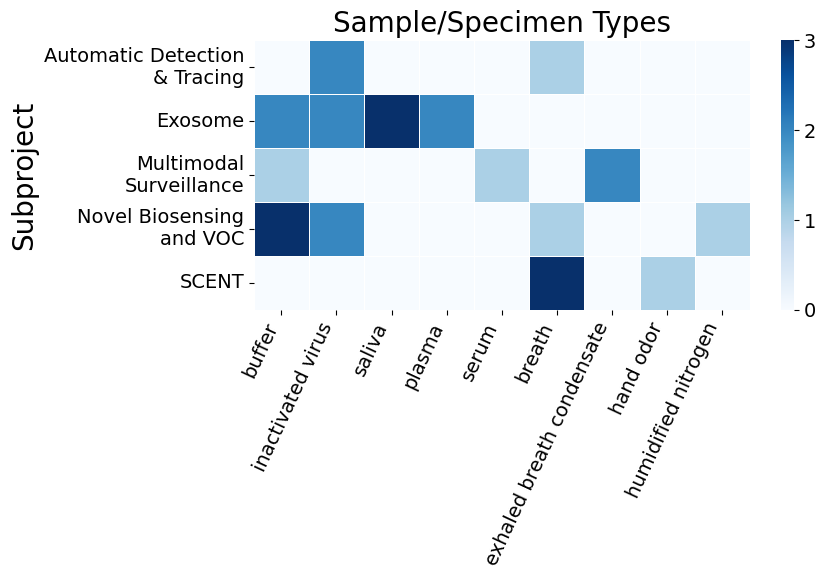

In [14]:
# Heatmap of specimen_type by subproject
desired_order = [
    "buffer",
    "inactivated virus",
    "saliva", "plasma", "serum",
    "breath", "exhaled breath condensate",
    "hand odor", "humidified nitrogen",
]

pivot = (
    characteristics[characteristics['characteristic'] == 'specimen_type']
      .pivot_table(index='subproject', columns='value', aggfunc='size', fill_value=0)
)
pivot = pivot.reindex(columns=desired_order, fill_value=0)

plt.figure(figsize=(8, 3.5))
ax = sns.heatmap(pivot, cmap='Blues', linewidths=0.5)

# Force integer ticks on colorbar
cbar = ax.collections[0].colorbar
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()

# Wrap y-tick labels
ax.set_yticklabels([wrap_label(t.get_text(), limit=10) for t in ax.get_yticklabels()],
                   rotation=0, va='center')

# X axis cosmetics
plt.xticks(rotation=65, ha='right')

plt.ylabel("Subproject", fontsize=20)
plt.xlabel("")
plt.title("Sample/Specimen Types", fontsize=20)
#plt.tight_layout()
plt.show()


In [15]:
cols = ["virus_shortname", "pango_lineage", "who_label", "virus_shortname", "virus_sample_source", "virus_sample_type", "virus_sample_inactivation_method"]
characteristics = extract_data_element(df, cols)
characteristics["characteristic"] = characteristics["characteristic"].replace("virus_shortname", "pango_lineage")
characteristics = characteristics[characteristics["value"] != ""].copy()

In [16]:
characteristics.head(100)

,value,characteristic,phs_id,subproject
0,inactivated virus,virus_sample_type,phs002544.v1.p1,Exosome
1,Gamma-irradiated,virus_sample_inactivation_method,phs002544.v1.p1,Exosome
2,A,pango_lineage,phs002544.v1.p1,Exosome
7,heat,virus_sample_inactivation_method,phs002544.v1.p1,Exosome
9,BEI Resources,virus_sample_source,phs002544.v1.p1,Exosome
13,UCSD,virus_sample_source,phs002544.v1.p1,Exosome
20,A,pango_lineage,phs002546.v1.p1,Automatic Detection & Tracing
21,B.1.617.2,pango_lineage,phs002546.v1.p1,Automatic Detection & Tracing
23,Delta,who_label,phs002546.v1.p1,Automatic Detection & Tracing
24,UV,virus_sample_inactivation_method,phs002546.v1.p1,Automatic Detection & Tracing


In [17]:
characteristics.query("characteristic == 'pango_lineage'")

,value,characteristic,phs_id,subproject
2,A,pango_lineage,phs002544.v1.p1,Exosome
20,A,pango_lineage,phs002546.v1.p1,Automatic Detection & Tracing
21,B.1.617.2,pango_lineage,phs002546.v1.p1,Automatic Detection & Tracing
39,A,pango_lineage,phs002583.v1.p1,Novel Biosensing and VOC
43,BA.5.1,pango_lineage,phs002685.v1.p1,Novel Biosensing and VOC
44,B.1.1.529,pango_lineage,phs002685.v1.p1,Novel Biosensing and VOC
46,BA.5.1,pango_lineage,phs002685.v1.p1,Novel Biosensing and VOC
47,B.1.1.529,pango_lineage,phs002685.v1.p1,Novel Biosensing and VOC
58,BA.1,pango_lineage,phs002689.v1.p1,Novel Biosensing and VOC
59,XBB,pango_lineage,phs002689.v1.p1,Novel Biosensing and VOC


In [18]:
characteristics.query("characteristic == 'who_label'")

,value,characteristic,phs_id,subproject
23,Delta,who_label,phs002546.v1.p1,Automatic Detection & Tracing
30,wild type,who_label,phs002546.v1.p1,Automatic Detection & Tracing
31,Omicron,who_label,phs002546.v1.p1,Automatic Detection & Tracing
45,Omicron,who_label,phs002685.v1.p1,Novel Biosensing and VOC
60,Omicron,who_label,phs002689.v1.p1,Novel Biosensing and VOC
79,Delta,who_label,phs002744.v1.p1,Automatic Detection & Tracing
80,Omicron,who_label,phs002744.v1.p1,Automatic Detection & Tracing
90,Alpha,who_label,phs002778.v1.p1,Exosome
92,Beta,who_label,phs002778.v1.p1,Exosome
93,Omicron,who_label,phs002778.v1.p1,Exosome


In [19]:
characteristics.query("characteristic == 'virus_sample_inactivation_method'")

,value,characteristic,phs_id,subproject
1,Gamma-irradiated,virus_sample_inactivation_method,phs002544.v1.p1,Exosome
7,heat,virus_sample_inactivation_method,phs002544.v1.p1,Exosome
24,UV,virus_sample_inactivation_method,phs002546.v1.p1,Automatic Detection & Tracing
54,UV,virus_sample_inactivation_method,phs002685.v1.p1,Novel Biosensing and VOC
63,Gamma-irradiated,virus_sample_inactivation_method,phs002689.v1.p1,Novel Biosensing and VOC
84,UV,virus_sample_inactivation_method,phs002744.v1.p1,Automatic Detection & Tracing
96,UV,virus_sample_inactivation_method,phs002778.v1.p1,Exosome
97,heat,virus_sample_inactivation_method,phs002778.v1.p1,Exosome


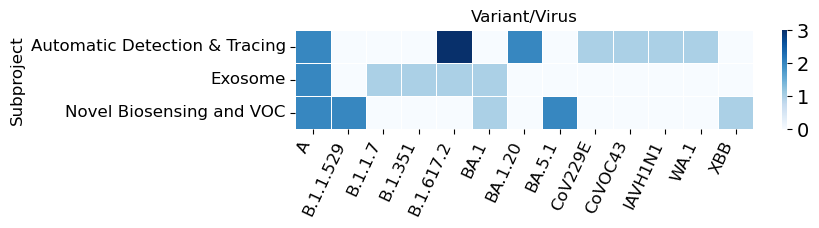

In [20]:
# Sorted, case‐insensitive list of all subprojects
all_subprojects = sorted(characteristics['subproject'].unique(), key=str.lower)

# Characteristic and title to plot
char, title = ('pango_lineage', 'Variant/Virus')

# Build pivot table
piv = (
    characteristics[characteristics['characteristic'] == char]
    .pivot_table(
        index='subproject',
        columns='value',
        aggfunc='size',
        fill_value=0
    )
)
piv = piv.reindex(index=all_subprojects, fill_value=0)
sorted_cols = sorted(piv.columns, key=str.lower)
piv = piv.reindex(columns=sorted_cols, fill_value=0)

# vmin/vmax for color scale
vmin, vmax = piv.values.min(), piv.values.max()

# Plot
fig, ax = plt.subplots(figsize=(9, 2.5))
heat = sns.heatmap(
    piv,
    ax=ax,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    cbar=True
)

ax.set_title(title, fontsize=12)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=65, labelsize=12)
for lbl in ax.get_xticklabels():
    lbl.set_ha('right')

# Add y-axis label and adjust tick labels
ax.set_ylabel('Subproject', fontsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=12)
for lbl in ax.get_yticklabels():
    lbl.set_ha('right')

# Force integer ticks on the colorbar
cbar = heat.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


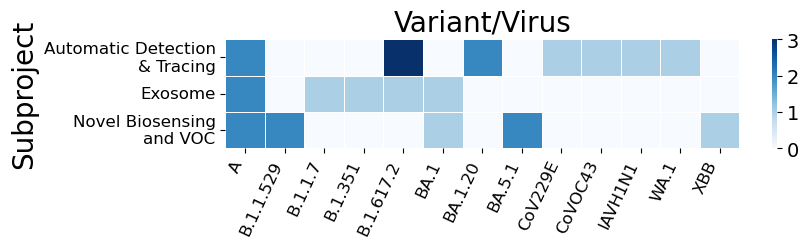

In [21]:
# Sorted, case-insensitive list of all subprojects
all_subprojects = sorted(characteristics['subproject'].unique(), key=str.lower)

# Characteristic and title to plot
char, title = ('pango_lineage', 'Variant/Virus')

# Build pivot table
piv = (
    characteristics[characteristics['characteristic'] == char]
    .pivot_table(
        index='subproject',
        columns='value',
        aggfunc='size',
        fill_value=0
    )
)
piv = piv.reindex(index=all_subprojects, fill_value=0)
sorted_cols = sorted(piv.columns, key=str.lower)
piv = piv.reindex(columns=sorted_cols, fill_value=0)

# vmin/vmax for color scale
vmin, vmax = piv.values.min(), piv.values.max()

# Plot
fig, ax = plt.subplots(figsize=(9, 2.7))
heat = sns.heatmap(
    piv,
    ax=ax,
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    cbar=True
)

ax.set_title(title, fontsize=20)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=65, labelsize=12)
for lbl in ax.get_xticklabels():
    lbl.set_ha('right')

# Wrap y-tick labels
ax.set_ylabel('Subproject', fontsize=20)
ax.tick_params(axis='y', labelrotation=0, labelsize=12)
ax.set_yticklabels(
    [wrap_label(lbl.get_text(), limit=10) for lbl in ax.get_yticklabels()],
    rotation=0, ha='right'
)

# Force integer ticks on the colorbar
cbar = heat.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


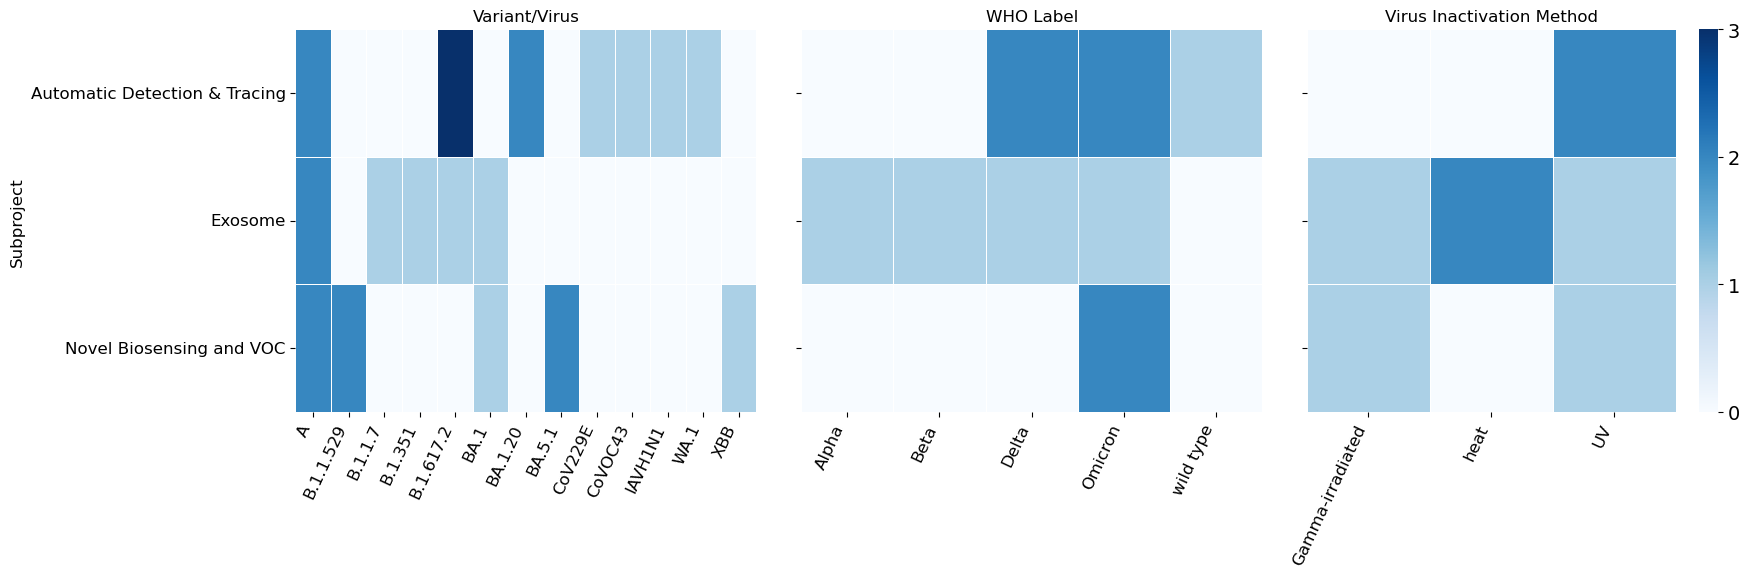

In [22]:
# Sorted, case‐insensitive list of all subprojects
all_subprojects = sorted(characteristics['subproject'].unique(), key=str.lower)

# Which characteristics to plot
chars = [
    ('pango_lineage', 'Variant/Virus'),
    ('who_label',      'WHO Label'),
    ('virus_sample_inactivation_method', 'Virus Inactivation Method'),
]

# 3) First pass: build each pivot & track global vmin/vmax
pivots = []
vmin, vmax = np.inf, -np.inf

for char, title in chars:
    piv = (
        characteristics
          [characteristics['characteristic'] == char]
          .pivot_table(
              index='subproject',
              columns='value',
              aggfunc='size',
              fill_value=0
          )
    )
    piv = piv.reindex(index=all_subprojects, fill_value=0)
    sorted_cols = sorted(piv.columns, key=str.lower)
    piv = piv.reindex(columns=sorted_cols, fill_value=0)

    pivots.append((piv, title))
    vmin = min(vmin, piv.values.min())
    vmax = max(vmax, piv.values.max())

# Plot: share y, one colorbar on last, one y‐axis label on first
fig, axes = plt.subplots(
    ncols=len(chars),
    sharey=True,
    figsize=(6 * len(chars), 6)
)

for idx, (ax, (pivot, title)) in enumerate(zip(axes, pivots)):
    draw_cbar = (idx == len(chars) - 1)
    heat = sns.heatmap(
        pivot,
        ax=ax,
        cmap='Blues',
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        cbar=draw_cbar
    )

    ax.set_title(title, fontsize=12)

    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=65, labelsize=12)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('right')

    # remove any y‐axis title on all subplots
    ax.set_ylabel('')

    if draw_cbar:
        # only force integer ticks on the single colorbar
        cbar = heat.collections[0].colorbar
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Add the y‐axis label on the FIRST subplot, and make its tick labels horizontal
axes[0].set_ylabel('Subproject', fontsize=12)
axes[0].tick_params(axis='y', labelrotation=0, labelsize=12)
for lbl in axes[0].get_yticklabels():
    lbl.set_ha('right')

plt.tight_layout()
plt.show()